In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'Pará - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_PA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Pará - IDH Educacao,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - Consumo de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - IDH Renda,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.614461,8.348543,2.208327e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.618560,84.701,0.312867,0.748453,10387.404000,0.648977,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.614718,8.342554,2.222364e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.658098,80.221,0.312657,0.748776,10470.519385,0.649037,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.614976,8.336566,2.236400e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.906876,76.122,0.311736,0.749099,10546.359385,0.649097,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.615233,8.330578,2.250437e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.864305,76.544,0.310493,0.749421,10614.915813,0.649156,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.615490,8.324589,2.264474e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.179753,83.445,0.309128,0.749744,10682.772020,0.649216,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36200.254402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36157.819932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36097.250375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36021.389035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


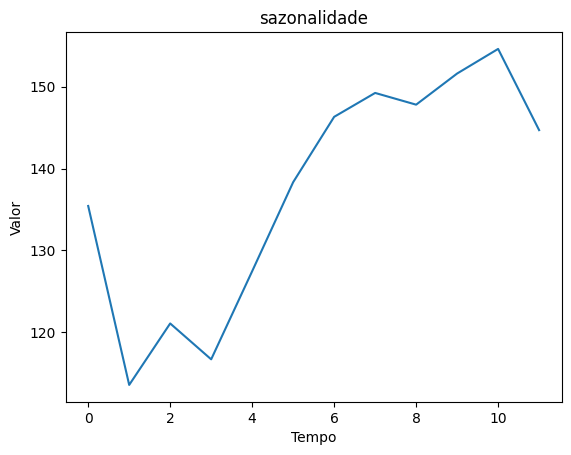

,sazonalidade
sazonalidade,
0,135.432930
1,113.562628
2,121.075051
3,116.689421
4,127.459408
5,138.339749
6,146.326370
7,149.248256
8,147.814747


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Pará - IDH Educacao,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - IDH Renda,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Pará - Consumo de Cimento (t)
0,2003-1,0.614461,8.348543,2.208327e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.618560,0.312867,0.748453,10387.404000,0.648977,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,135.432930,84.701
1,2003-2,0.614718,8.342554,2.222364e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.658098,0.312657,0.748776,10470.519385,0.649037,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,113.562628,80.221
2,2003-3,0.614976,8.336566,2.236400e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.906876,0.311736,0.749099,10546.359385,0.649097,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,121.075051,76.122
3,2003-4,0.615233,8.330578,2.250437e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.864305,0.310493,0.749421,10614.915813,0.649156,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,116.689421,76.544
4,2003-5,0.615490,8.324589,2.264474e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.179753,0.309128,0.749744,10682.772020,0.649216,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,127.459408,83.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36200.254402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.459408,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36157.819932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.339749,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36097.250375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,146.326370,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36021.389035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,149.248256,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Pará - Consumo de Cimento (t), Length: 249, dtype: float64

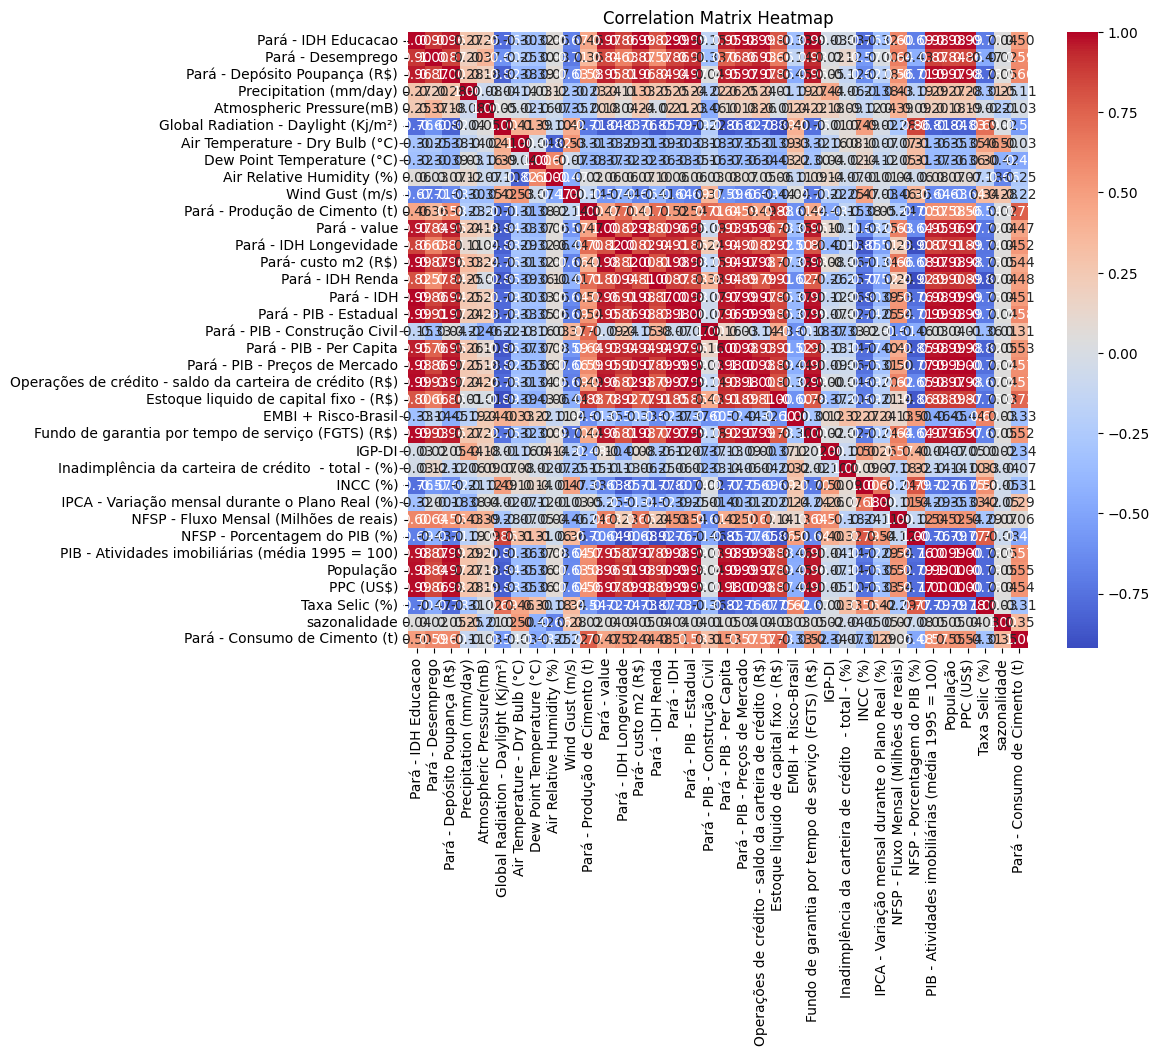

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Pará - IDH Educacao,4.238188e+08
1,Pará - Desemprego,2.434492e+03
2,Pará - Depósito Poupança (R$),1.594384e+04
3,Precipitation (mm/day),1.647157e+01
4,Atmospheric Pressure(mB),1.303049e+05
5,Global Radiation - Daylight (Kj/m²),6.090436e+01
6,Air Temperature - Dry Bulb (°C),1.647261e+05
7,Dew Point Temperature (°C),1.031435e+05
8,Air Relative Humidity (%),7.696970e+04
9,Wind Gust (m/s),3.166132e+01


In [39]:
data =data.fillna(0.0).drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 8


,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - PIB - Estadual,Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,8.348543,2.208327e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.618560,0.312867,0.748453,10387.404000,7.776091e+07,4.250430e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,135.432930
1,8.342554,2.222364e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.658098,0.312657,0.748776,10470.519385,7.787181e+07,4.255476e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,113.562628
2,8.336566,2.236400e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.906876,0.311736,0.749099,10546.359385,7.798271e+07,4.260521e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,121.075051
3,8.330578,2.250437e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.864305,0.310493,0.749421,10614.915813,7.809361e+07,4.265566e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,116.689421
4,8.324589,2.264474e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.179753,0.309128,0.749744,10682.772020,7.820451e+07,4.270611e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,127.459408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,10.141356,6.984274e+06,4.466403,1009.352839,968.451677,22.809313,78.437493,0.659690,74.462579,0.536782,0.765442,27210.785919,9.632115e+07,4.337388e+06,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,437.906135,0.516394,149.248256
200,10.136139,7.098075e+06,4.674377,1008.726399,967.277928,22.883378,78.525004,0.758441,74.127723,0.541273,0.765244,27418.604953,9.624751e+07,4.337915e+06,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,438.554287,0.509923,147.814747
201,10.130922,7.211875e+06,4.419135,1008.473254,917.834065,22.962557,79.505633,0.758122,73.850917,0.546419,0.765045,27660.733850,9.617387e+07,4.338443e+06,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,439.156241,0.467083,151.619417
202,10.125705,7.325676e+06,4.232790,1008.438742,853.121127,23.088812,80.835692,0.736708,73.576717,0.551661,0.764847,27905.587473,9.610023e+07,4.338970e+06,3.425371e+06,262.843441,1.165215e+07,1.180399,2.995976,0.663946,0.480964,6503.475785,1.810689,207.781676,439.704663,0.441494,154.627186


In [40]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - PIB - Estadual,Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.611795,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.822620,-1.040679,-2.799357,-1.539839,-1.702979,-1.767502,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.602056,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.821068,-1.043307,-2.739073,-1.523220,-1.686002,-1.714815,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.592317,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.811306,-1.054814,-2.678789,-1.508057,-1.669024,-1.662127,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.582579,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.812977,-1.070347,-2.618505,-1.494349,-1.652046,-1.609440,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.572840,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.800599,-1.087399,-2.558221,-1.480782,-1.635068,-1.556752,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,1.701742,1.609153,0.252322,-0.582729,0.215502,0.151964,-0.659971,-0.847760,1.756980,0.374266,1.823917,1.138433,-0.859390,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.402207,-1.370268
200,1.780696,1.840130,0.249683,-0.582948,0.229164,0.156555,-0.345340,-0.860899,1.813091,0.337229,1.865470,1.127160,-0.853883,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.410056,-1.390925
201,1.859651,1.556658,0.248616,-0.592158,0.243770,0.208005,-0.346357,-0.871761,1.877381,0.300193,1.913882,1.115886,-0.848376,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.417346,-1.527663
202,1.938605,1.349702,0.248471,-0.604212,0.267059,0.277789,-0.414583,-0.882520,1.942884,0.263156,1.962840,1.104612,-0.842869,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.423988,-1.609340


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - PIB - Estadual,Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,-1.611795,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.822620,-1.040679,-2.799357,-1.539839,-1.702979,-1.767502,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-1.851489,2.125141
1,-1.602056,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.821068,-1.043307,-2.739073,-1.523220,-1.686002,-1.714815,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-1.840236,1.610904
2,-1.592317,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.811306,-1.054814,-2.678789,-1.508057,-1.669024,-1.662127,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-1.828623,2.950828
3,-1.582579,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.812977,-1.070347,-2.618505,-1.494349,-1.652046,-1.609440,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.816740,1.307354
4,-1.572840,-3.351238,-3.999986,-0.763122,-3.991934,-3.963365,-2.761816,-1.800599,-1.087399,-2.558221,-1.480782,-1.635068,-1.556752,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.075455,2.097733,0.251538,-0.551655,0.180860,0.132773,-0.409892,-0.596869,1.221585,0.783816,1.469439,1.226810,-0.932722,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.279826,-1.152820
188,1.090176,1.986487,0.249925,-0.560719,0.197330,0.166018,-0.383992,-0.629506,1.245745,0.753758,1.490502,1.224917,-0.925765,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.291262,-1.253503
189,1.104897,1.597951,0.249838,-0.574259,0.218567,0.221916,-0.388115,-0.656542,1.281263,0.723699,1.513595,1.223025,-0.918808,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.301919,-1.425444
190,1.119618,0.873076,0.249881,-0.595838,0.248991,0.304841,-0.464416,-0.678693,1.321530,0.693640,1.536738,1.221133,-0.911852,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.311660,-1.237935


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
187    144.451
188    148.360
189    152.152
190    115.666
191    118.619
Name: Pará - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 25)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - PIB - Estadual,Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
156,0.635286,-0.148132,0.250229,-0.573578,0.322178,0.334437,-0.627532,0.682886,1.001740,1.491744,0.931157,1.088240,-1.040727,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.911463,0.407265
157,0.643711,0.015633,0.250844,-0.575686,0.348152,0.379929,-0.651748,0.639464,1.012607,1.473946,0.948399,1.098670,-1.046583,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.922870,0.137084
158,0.652135,-0.066732,0.252466,-0.574170,0.345499,0.369514,-0.640346,0.594933,1.022626,1.456148,0.964770,1.109100,-1.052439,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.935360,0.296087
159,0.660560,0.096536,0.253400,-0.565483,0.317303,0.316085,-0.530685,0.538273,1.032129,1.438350,0.980870,1.119530,-1.058296,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.948135,0.197300
160,0.668985,0.234252,0.255056,-0.556066,0.276268,0.250431,-0.414529,0.482682,1.037336,1.420552,0.997042,1.129960,-1.064152,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.961143,0.469403
161,0.677410,0.121307,0.255662,-0.547983,0.235319,0.188123,-0.383369,0.456536,1.042189,1.402754,1.013029,1.140390,-1.070008,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.973478,0.775434
162,0.685834,0.092383,0.254170,-0.539070,0.215244,0.124721,-0.265074,0.426043,1.046515,1.384956,1.029093,1.150820,-1.075865,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.985778,0.136553
163,0.694259,0.011403,0.252133,-0.535845,0.207809,0.072270,-0.074955,0.401321,1.049750,1.367158,1.045166,1.161251,-1.081721,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.999021,0.642038
164,0.702684,-0.179955,0.250148,-0.541355,0.222845,0.104151,-0.135340,0.365418,1.052158,1.349359,1.061321,1.171681,-1.087578,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,1.012408,0.482412
165,0.711109,-0.024727,0.248469,-0.549609,0.248112,0.179514,-0.232625,0.323182,1.054883,1.331561,1.079789,1.182111,-1.093434,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.025524,0.367764


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 25)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(180, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[3757047864, 2495133410, 3299628377, 627030575, 1672296309, 1109354187, 2543091625, 2178133887, 3189989953, 2242896774]


Step: 0 ___________________________________________
val_loss: 605.5005493164062
winner_seed: 3757047864


Step: 1 ___________________________________________
val_loss: 666.7517700195312


Step: 2 ___________________________________________
val_loss: 569.744873046875
winner_seed: 3299628377


Step: 3 ___________________________________________
val_loss: 22466279424.0


Step: 4 ___________________________________________
val_loss: 907.8156127929688


Step: 5 ___________________________________________
val_loss: 340.8316955566406
winner_seed: 1109354187


Step: 6 ___________________________________________
val_loss: 226.90518188476562
winner_seed: 2543091625


Step: 7 ___________________________________________
val_loss: 426.63653564453125


Step: 8 ___________________________________________
val_loss: 19778588.0


Step: 9 ___________________________________________
va

In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 1595719333

Epoch 1/10000
5/5 [==============================] - 2s 107ms/step - loss: 14097.0518 - val_loss: 1660.4042
Epoch 2/10000
5/5 [==============================] - 0s 10ms/step - loss: 1321.5006 - val_loss: 696.9240
Epoch 3/10000
5/5 [==============================] - 0s 11ms/step - loss: 1564.0100 - val_loss: 1241.4324
Epoch 4/10000
5/5 [==============================] - 0s 10ms/step - loss: 1496.0074 - val_loss: 693.5959
Epoch 5/10000
5/5 [==============================] - 0s 10ms/step - loss: 1349.8655 - val_loss: 693.4905
Epoch 6/10000
5/5 [==============================] - 0s 11ms/step - loss: 1385.3640 - val_loss: 1357.4026
Epoch 7/10000
5/5 [==============================] - 0s 10ms/step - loss: 1855.7164 - val_loss: 2534.7136
Epoch 8/10000
5/5 [==============================] - 0s 11ms/step - loss: 1187.6553 - val_loss: 737.2025
Epoch 9/10000
5/5 [==============================] - 0s 11ms/step - loss: 1516.3369 - val_loss: 1360.6382
Epoch 10/10000
5/5 [============================

Epoch 79/10000
5/5 [==============================] - 0s 9ms/step - loss: 247.0309 - val_loss: 588.7966
Epoch 80/10000
5/5 [==============================] - 0s 10ms/step - loss: 253.9670 - val_loss: 623.8889
Epoch 81/10000
5/5 [==============================] - 0s 11ms/step - loss: 246.9729 - val_loss: 601.0404
Epoch 82/10000
5/5 [==============================] - 0s 11ms/step - loss: 364.5495 - val_loss: 572.0734
Epoch 83/10000
5/5 [==============================] - 0s 11ms/step - loss: 259.5332 - val_loss: 640.7850
Epoch 84/10000
5/5 [==============================] - 0s 11ms/step - loss: 267.4554 - val_loss: 546.2662
Epoch 85/10000
5/5 [==============================] - 0s 11ms/step - loss: 352.1915 - val_loss: 593.2888
Epoch 86/10000
5/5 [==============================] - 0s 11ms/step - loss: 254.1637 - val_loss: 531.6245
Epoch 87/10000
5/5 [==============================] - 0s 11ms/step - loss: 299.7479 - val_loss: 625.0628
Epoch 88/10000
5/5 [==============================] - 0s

5/5 [==============================] - 0s 10ms/step - loss: 170.0205 - val_loss: 427.4532
Epoch 157/10000
5/5 [==============================] - 0s 10ms/step - loss: 161.4584 - val_loss: 298.4729
Epoch 158/10000
5/5 [==============================] - 0s 11ms/step - loss: 170.4364 - val_loss: 348.9169
Epoch 159/10000
5/5 [==============================] - 0s 11ms/step - loss: 207.0362 - val_loss: 752.7252
Epoch 160/10000
5/5 [==============================] - 0s 10ms/step - loss: 192.3741 - val_loss: 417.7705
Epoch 161/10000
5/5 [==============================] - 0s 10ms/step - loss: 163.5493 - val_loss: 311.6146
Epoch 162/10000
5/5 [==============================] - 0s 11ms/step - loss: 173.2808 - val_loss: 308.5010
Epoch 163/10000
5/5 [==============================] - 0s 11ms/step - loss: 259.1684 - val_loss: 455.6797
Epoch 164/10000
5/5 [==============================] - 0s 10ms/step - loss: 162.1044 - val_loss: 274.0612
Epoch 165/10000
5/5 [==============================] - 0s 12ms

5/5 [==============================] - 0s 9ms/step - loss: 134.9104 - val_loss: 284.3948
Epoch 234/10000
5/5 [==============================] - 0s 9ms/step - loss: 130.1247 - val_loss: 262.4482
Epoch 235/10000
5/5 [==============================] - 0s 10ms/step - loss: 136.5764 - val_loss: 388.7551
Epoch 236/10000
5/5 [==============================] - 0s 9ms/step - loss: 143.8321 - val_loss: 328.7585
Epoch 237/10000
5/5 [==============================] - 0s 10ms/step - loss: 147.2769 - val_loss: 405.1466
Epoch 238/10000
5/5 [==============================] - 0s 11ms/step - loss: 524.6119 - val_loss: 427.1820
Epoch 239/10000
5/5 [==============================] - 0s 11ms/step - loss: 181.6311 - val_loss: 840.1789
Epoch 240/10000
5/5 [==============================] - 0s 10ms/step - loss: 301.0440 - val_loss: 291.4936
Epoch 241/10000
5/5 [==============================] - 0s 9ms/step - loss: 158.4415 - val_loss: 303.0906
Epoch 242/10000
5/5 [==============================] - 0s 10ms/ste

5/5 [==============================] - 0s 11ms/step - loss: 127.3704 - val_loss: 252.1502
Epoch 311/10000
5/5 [==============================] - 0s 12ms/step - loss: 140.8367 - val_loss: 335.0564
Epoch 312/10000
5/5 [==============================] - 0s 12ms/step - loss: 155.5899 - val_loss: 313.8916
Epoch 313/10000
5/5 [==============================] - 0s 11ms/step - loss: 139.5200 - val_loss: 251.0709
Epoch 314/10000
5/5 [==============================] - 0s 11ms/step - loss: 130.7843 - val_loss: 248.8458
Epoch 315/10000
5/5 [==============================] - 0s 13ms/step - loss: 132.0774 - val_loss: 219.5344
Epoch 316/10000
5/5 [==============================] - 0s 9ms/step - loss: 137.4826 - val_loss: 257.4221
Epoch 317/10000
5/5 [==============================] - 0s 10ms/step - loss: 121.4200 - val_loss: 303.3799
Epoch 318/10000
5/5 [==============================] - 0s 12ms/step - loss: 163.6250 - val_loss: 330.9352
Epoch 319/10000
5/5 [==============================] - 0s 10ms/

Epoch 388/10000
5/5 [==============================] - 0s 10ms/step - loss: 120.9767 - val_loss: 275.8071
Epoch 389/10000
5/5 [==============================] - 0s 11ms/step - loss: 66.9334 - val_loss: 251.7262
Epoch 390/10000
5/5 [==============================] - 0s 11ms/step - loss: 67.1024 - val_loss: 232.9585
Epoch 391/10000
5/5 [==============================] - 0s 10ms/step - loss: 61.7204 - val_loss: 372.6102
Epoch 392/10000
5/5 [==============================] - 0s 10ms/step - loss: 72.6935 - val_loss: 278.4669
Epoch 393/10000
5/5 [==============================] - 0s 10ms/step - loss: 53.2173 - val_loss: 256.4281
Epoch 394/10000
5/5 [==============================] - 0s 10ms/step - loss: 53.4727 - val_loss: 429.9199
Epoch 395/10000
5/5 [==============================] - 0s 10ms/step - loss: 79.9367 - val_loss: 275.5439
Epoch 396/10000
5/5 [==============================] - 0s 9ms/step - loss: 54.1566 - val_loss: 284.5854
Epoch 397/10000
5/5 [==============================] - 

5/5 [==============================] - 0s 10ms/step - loss: 62.1271 - val_loss: 334.1329
Epoch 467/10000
5/5 [==============================] - 0s 10ms/step - loss: 38.8679 - val_loss: 371.0722
Epoch 468/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.8911 - val_loss: 329.1970
Epoch 469/10000
5/5 [==============================] - 0s 10ms/step - loss: 42.5698 - val_loss: 372.4446
Epoch 470/10000
5/5 [==============================] - 0s 11ms/step - loss: 37.6251 - val_loss: 330.9198
Epoch 471/10000
5/5 [==============================] - 0s 10ms/step - loss: 38.6062 - val_loss: 303.1157
Epoch 472/10000
5/5 [==============================] - 0s 10ms/step - loss: 36.5177 - val_loss: 296.5030
Epoch 473/10000
5/5 [==============================] - 0s 11ms/step - loss: 40.1729 - val_loss: 343.9901
Epoch 474/10000
5/5 [==============================] - 0s 10ms/step - loss: 35.6926 - val_loss: 349.7951
Epoch 475/10000
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 10ms/step - loss: 44.2921 - val_loss: 348.5042
Epoch 545/10000
5/5 [==============================] - 0s 9ms/step - loss: 27.7156 - val_loss: 321.6660
Epoch 546/10000
5/5 [==============================] - 0s 10ms/step - loss: 28.9820 - val_loss: 311.0661
Epoch 547/10000
5/5 [==============================] - 0s 11ms/step - loss: 36.9702 - val_loss: 346.7508
Epoch 548/10000
5/5 [==============================] - 0s 11ms/step - loss: 36.0665 - val_loss: 350.7849
Epoch 549/10000
5/5 [==============================] - 0s 10ms/step - loss: 33.1094 - val_loss: 343.4341
Epoch 550/10000
5/5 [==============================] - 0s 11ms/step - loss: 32.6483 - val_loss: 320.9436
Epoch 551/10000
5/5 [==============================] - 0s 11ms/step - loss: 35.0033 - val_loss: 345.5303
Epoch 552/10000
5/5 [==============================] - 0s 11ms/step - loss: 33.4109 - val_loss: 379.6499
Epoch 553/10000
5/5 [==============================] - 0s 11ms/step - lo

5/5 [==============================] - 0s 10ms/step - loss: 24.9422 - val_loss: 281.5386
Epoch 623/10000
5/5 [==============================] - 0s 11ms/step - loss: 27.1708 - val_loss: 298.6275
Epoch 624/10000
5/5 [==============================] - 0s 11ms/step - loss: 26.7714 - val_loss: 289.4534
Epoch 625/10000
5/5 [==============================] - 0s 11ms/step - loss: 28.4085 - val_loss: 347.6764
Epoch 626/10000
5/5 [==============================] - 0s 10ms/step - loss: 27.2954 - val_loss: 358.8295
Epoch 627/10000
5/5 [==============================] - 0s 11ms/step - loss: 29.6429 - val_loss: 339.9985
Epoch 628/10000
5/5 [==============================] - 0s 11ms/step - loss: 29.2663 - val_loss: 307.9998
Epoch 629/10000
5/5 [==============================] - 0s 11ms/step - loss: 27.3669 - val_loss: 328.0913
Epoch 630/10000
5/5 [==============================] - 0s 9ms/step - loss: 26.1537 - val_loss: 363.7107
Epoch 631/10000
5/5 [==============================] - 0s 12ms/step - lo

5/5 [==============================] - 0s 10ms/step - loss: 25.4614 - val_loss: 344.5333
Epoch 701/10000
5/5 [==============================] - 0s 11ms/step - loss: 23.2282 - val_loss: 371.7318
Epoch 702/10000
5/5 [==============================] - 0s 12ms/step - loss: 22.4633 - val_loss: 318.9656
Epoch 703/10000
5/5 [==============================] - 0s 11ms/step - loss: 24.7576 - val_loss: 318.5676
Epoch 704/10000
5/5 [==============================] - 0s 11ms/step - loss: 24.6439 - val_loss: 283.8063
Epoch 705/10000
5/5 [==============================] - 0s 11ms/step - loss: 29.7962 - val_loss: 329.6755
Epoch 706/10000
5/5 [==============================] - 0s 11ms/step - loss: 41.7530 - val_loss: 324.6198
Epoch 707/10000
5/5 [==============================] - 0s 10ms/step - loss: 31.1358 - val_loss: 339.4530
Epoch 708/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.3183 - val_loss: 327.1101
Epoch 709/10000
5/5 [==============================] - 0s 9ms/step - lo

5/5 [==============================] - 0s 11ms/step - loss: 36.7170 - val_loss: 314.4815
Epoch 779/10000
5/5 [==============================] - 0s 11ms/step - loss: 21.3797 - val_loss: 340.5490
Epoch 780/10000
5/5 [==============================] - 0s 11ms/step - loss: 21.4076 - val_loss: 308.8926
Epoch 781/10000
5/5 [==============================] - 0s 11ms/step - loss: 22.1106 - val_loss: 315.7476
Epoch 782/10000
5/5 [==============================] - 0s 10ms/step - loss: 21.9376 - val_loss: 283.6238
Epoch 783/10000
5/5 [==============================] - 0s 10ms/step - loss: 33.7281 - val_loss: 380.4751
Epoch 784/10000
5/5 [==============================] - 0s 10ms/step - loss: 30.8969 - val_loss: 337.0325
Epoch 785/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.7780 - val_loss: 301.3140
Epoch 786/10000
5/5 [==============================] - 0s 11ms/step - loss: 25.0169 - val_loss: 284.5168
Epoch 787/10000
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 22.7770 - val_loss: 265.6456
Epoch 857/10000
5/5 [==============================] - 0s 10ms/step - loss: 30.3167 - val_loss: 287.0321
Epoch 858/10000
5/5 [==============================] - 0s 12ms/step - loss: 74.3380 - val_loss: 321.0308
Epoch 859/10000
5/5 [==============================] - 0s 10ms/step - loss: 25.6335 - val_loss: 331.8354
Epoch 860/10000
5/5 [==============================] - 0s 11ms/step - loss: 21.1886 - val_loss: 286.8192
Epoch 861/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.2927 - val_loss: 292.6550
Epoch 862/10000
5/5 [==============================] - 0s 11ms/step - loss: 26.4234 - val_loss: 285.5927
Epoch 863/10000
5/5 [==============================] - 0s 12ms/step - loss: 22.7712 - val_loss: 292.8046
Epoch 864/10000
5/5 [==============================] - 0s 12ms/step - loss: 23.3713 - val_loss: 299.2233
Epoch 865/10000
5/5 [==============================] - 0s 11ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 18.8487 - val_loss: 272.0887
Epoch 935/10000
5/5 [==============================] - 0s 10ms/step - loss: 20.1009 - val_loss: 307.4661
Epoch 936/10000
5/5 [==============================] - 0s 10ms/step - loss: 19.7090 - val_loss: 320.2499
Epoch 937/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.0530 - val_loss: 266.9539
Epoch 938/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.2704 - val_loss: 290.2216
Epoch 939/10000
5/5 [==============================] - 0s 10ms/step - loss: 23.4691 - val_loss: 268.1132
Epoch 940/10000
5/5 [==============================] - 0s 10ms/step - loss: 20.6195 - val_loss: 290.4284
Epoch 941/10000
5/5 [==============================] - 0s 10ms/step - loss: 22.1687 - val_loss: 302.5606
Epoch 942/10000
5/5 [==============================] - 0s 10ms/step - loss: 18.7739 - val_loss: 294.0717
Epoch 943/10000
5/5 [==============================] - 0s 10ms/step - lo

5/5 [==============================] - 0s 11ms/step - loss: 21.0798 - val_loss: 261.7253
Epoch 1013/10000
5/5 [==============================] - 0s 11ms/step - loss: 18.0565 - val_loss: 265.2036
Epoch 1014/10000
5/5 [==============================] - 0s 11ms/step - loss: 17.4419 - val_loss: 344.3694
Epoch 1015/10000
5/5 [==============================] - 0s 10ms/step - loss: 19.2892 - val_loss: 280.8188
Epoch 1016/10000
5/5 [==============================] - 0s 11ms/step - loss: 22.5323 - val_loss: 296.7505
Epoch 1017/10000
5/5 [==============================] - 0s 11ms/step - loss: 22.1633 - val_loss: 276.1019
Epoch 1018/10000
5/5 [==============================] - 0s 11ms/step - loss: 17.1310 - val_loss: 306.9986
Epoch 1019/10000
5/5 [==============================] - 0s 11ms/step - loss: 17.4940 - val_loss: 299.4519
Epoch 1020/10000
5/5 [==============================] - 0s 11ms/step - loss: 17.8051 - val_loss: 290.3070
Epoch 1021/10000
5/5 [==============================] - 0s 10ms

Epoch 1090/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.5450 - val_loss: 281.0074
Epoch 1091/10000
5/5 [==============================] - 0s 8ms/step - loss: 31.1264 - val_loss: 344.0844
Epoch 1092/10000
5/5 [==============================] - 0s 8ms/step - loss: 36.7588 - val_loss: 271.7133
Epoch 1093/10000
5/5 [==============================] - 0s 8ms/step - loss: 34.4968 - val_loss: 354.7099
Epoch 1094/10000
5/5 [==============================] - 0s 8ms/step - loss: 32.2286 - val_loss: 275.5645
Epoch 1095/10000
5/5 [==============================] - 0s 8ms/step - loss: 18.0105 - val_loss: 260.2214
Epoch 1096/10000
5/5 [==============================] - 0s 8ms/step - loss: 21.2282 - val_loss: 248.5520
Epoch 1097/10000
5/5 [==============================] - 0s 7ms/step - loss: 16.9604 - val_loss: 264.5660
Epoch 1098/10000
5/5 [==============================] - 0s 7ms/step - loss: 18.2662 - val_loss: 260.5579
Epoch 1099/10000
5/5 [==============================] -

Epoch 1168/10000
5/5 [==============================] - 0s 11ms/step - loss: 16.1296 - val_loss: 285.1027
Epoch 1169/10000
5/5 [==============================] - 0s 11ms/step - loss: 16.5311 - val_loss: 272.9431
Epoch 1170/10000
5/5 [==============================] - 0s 11ms/step - loss: 14.6521 - val_loss: 303.3795
Epoch 1171/10000
5/5 [==============================] - 0s 10ms/step - loss: 18.1551 - val_loss: 320.5370
Epoch 1172/10000
5/5 [==============================] - 0s 11ms/step - loss: 18.0508 - val_loss: 282.3143
Epoch 1173/10000
5/5 [==============================] - 0s 10ms/step - loss: 18.1902 - val_loss: 272.8196
Epoch 1174/10000
5/5 [==============================] - 0s 11ms/step - loss: 17.0691 - val_loss: 283.5191
Epoch 1175/10000
5/5 [==============================] - 0s 11ms/step - loss: 16.6854 - val_loss: 251.3255
Epoch 1176/10000
5/5 [==============================] - 0s 10ms/step - loss: 17.1305 - val_loss: 295.1103
Epoch 1177/10000
5/5 [========================

5/5 [==============================] - 0s 11ms/step - loss: 15.1809 - val_loss: 290.6779
Epoch 1246/10000
5/5 [==============================] - 0s 11ms/step - loss: 19.0226 - val_loss: 226.9052
Epoch 1247/10000
5/5 [==============================] - 0s 13ms/step - loss: 21.1764 - val_loss: 303.4211
Epoch 1248/10000
5/5 [==============================] - 0s 12ms/step - loss: 14.5966 - val_loss: 293.2818
Epoch 1249/10000
5/5 [==============================] - 0s 11ms/step - loss: 14.3985 - val_loss: 280.1973
Epoch 1250/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.7052 - val_loss: 305.0861
Epoch 1251/10000
5/5 [==============================] - 0s 12ms/step - loss: 15.0963 - val_loss: 258.2013
Epoch 1252/10000
5/5 [==============================] - 0s 9ms/step - loss: 18.7966 - val_loss: 319.2828
Epoch 1253/10000
5/5 [==============================] - 0s 12ms/step - loss: 51.4866 - val_loss: 270.0975
Epoch 1254/10000
5/5 [==============================] - 0s 10ms/s

5/5 [==============================] - 0s 10ms/step - loss: 20.6982 - val_loss: 265.7471
Epoch 1323/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.9006 - val_loss: 276.2317
Epoch 1324/10000
5/5 [==============================] - 0s 11ms/step - loss: 20.0896 - val_loss: 285.6789
Epoch 1325/10000
5/5 [==============================] - 0s 11ms/step - loss: 14.1100 - val_loss: 279.1119
Epoch 1326/10000
5/5 [==============================] - 0s 11ms/step - loss: 24.4089 - val_loss: 252.6718
Epoch 1327/10000
5/5 [==============================] - 0s 11ms/step - loss: 14.8061 - val_loss: 263.0762
Epoch 1328/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.4012 - val_loss: 256.9203
Epoch 1329/10000
5/5 [==============================] - 0s 11ms/step - loss: 14.3419 - val_loss: 279.7897
Epoch 1330/10000
5/5 [==============================] - 0s 11ms/step - loss: 17.3705 - val_loss: 273.3232
Epoch 1331/10000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 10ms/step - loss: 13.9491 - val_loss: 304.2666
Epoch 1400/10000
5/5 [==============================] - 0s 8ms/step - loss: 12.5313 - val_loss: 298.4358
Epoch 1401/10000
5/5 [==============================] - 0s 10ms/step - loss: 16.8456 - val_loss: 284.5252
Epoch 1402/10000
5/5 [==============================] - 0s 12ms/step - loss: 13.4735 - val_loss: 269.5234
Epoch 1403/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.1340 - val_loss: 305.0161
Epoch 1404/10000
5/5 [==============================] - 0s 10ms/step - loss: 15.0529 - val_loss: 256.2555
Epoch 1405/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.3110 - val_loss: 273.7008
Epoch 1406/10000
5/5 [==============================] - 0s 11ms/step - loss: 12.4951 - val_loss: 276.4153
Epoch 1407/10000
5/5 [==============================] - 0s 11ms/step - loss: 13.1543 - val_loss: 268.4113
Epoch 1408/10000
5/5 [==============================] - 0s 11ms/st

5/5 [==============================] - 0s 11ms/step - loss: 14.3983 - val_loss: 273.9656
Epoch 1477/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.5002 - val_loss: 297.0800
Epoch 1478/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.0127 - val_loss: 294.9011
Epoch 1479/10000
5/5 [==============================] - 0s 11ms/step - loss: 13.5482 - val_loss: 288.3023
Epoch 1480/10000
5/5 [==============================] - 0s 11ms/step - loss: 13.5175 - val_loss: 310.9008
Epoch 1481/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.8664 - val_loss: 288.2250
Epoch 1482/10000
5/5 [==============================] - 0s 12ms/step - loss: 12.3102 - val_loss: 277.9650
Epoch 1483/10000
5/5 [==============================] - 0s 11ms/step - loss: 12.5060 - val_loss: 276.3408
Epoch 1484/10000
5/5 [==============================] - 0s 11ms/step - loss: 21.3201 - val_loss: 301.0558
Epoch 1485/10000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 11ms/step - loss: 12.4654 - val_loss: 303.3225
Epoch 1554/10000
5/5 [==============================] - 0s 11ms/step - loss: 12.3091 - val_loss: 326.6285
Epoch 1555/10000
5/5 [==============================] - 0s 11ms/step - loss: 12.7728 - val_loss: 290.8041
Epoch 1556/10000
5/5 [==============================] - 0s 11ms/step - loss: 13.0873 - val_loss: 274.4474
Epoch 1557/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.6788 - val_loss: 278.3299
Epoch 1558/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.0459 - val_loss: 290.1558
Epoch 1559/10000
5/5 [==============================] - 0s 11ms/step - loss: 13.0305 - val_loss: 272.7553
Epoch 1560/10000
5/5 [==============================] - 0s 10ms/step - loss: 20.3982 - val_loss: 293.3979
Epoch 1561/10000
5/5 [==============================] - 0s 10ms/step - loss: 13.3468 - val_loss: 269.0932
Epoch 1562/10000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 10ms/step - loss: 10.9222 - val_loss: 280.3644
Epoch 1631/10000
5/5 [==============================] - 0s 12ms/step - loss: 11.3705 - val_loss: 281.7431
Epoch 1632/10000
5/5 [==============================] - 0s 10ms/step - loss: 12.7818 - val_loss: 274.0881
Epoch 1633/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.9775 - val_loss: 270.0849
Epoch 1634/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.1033 - val_loss: 272.9161
Epoch 1635/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.2842 - val_loss: 292.0074
Epoch 1636/10000
5/5 [==============================] - 0s 11ms/step - loss: 10.7746 - val_loss: 281.4497
Epoch 1637/10000
5/5 [==============================] - 0s 11ms/step - loss: 12.2553 - val_loss: 297.6164
Epoch 1638/10000
5/5 [==============================] - 0s 12ms/step - loss: 13.5815 - val_loss: 298.7934
Epoch 1639/10000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 11ms/step - loss: 11.9604 - val_loss: 357.4560
Epoch 1708/10000
5/5 [==============================] - 0s 10ms/step - loss: 11.0384 - val_loss: 295.7435
Epoch 1709/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.8671 - val_loss: 270.3084
Epoch 1710/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.9574 - val_loss: 310.5364
Epoch 1711/10000
5/5 [==============================] - 0s 10ms/step - loss: 14.2397 - val_loss: 279.5573
Epoch 1712/10000
5/5 [==============================] - 0s 9ms/step - loss: 14.6299 - val_loss: 323.0486
Epoch 1713/10000
5/5 [==============================] - 0s 9ms/step - loss: 12.4934 - val_loss: 297.7599
Epoch 1714/10000
5/5 [==============================] - 0s 9ms/step - loss: 13.2119 - val_loss: 295.6818
Epoch 1715/10000
5/5 [==============================] - 0s 11ms/step - loss: 11.1723 - val_loss: 321.7346
Epoch 1716/10000
5/5 [==============================] - 0s 11ms/st

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 15ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,131.046616,129.080734,127.597893,129.238647,131.082718,130.524872,130.805313,131.309158,131.558014,132.085678,132.202225,131.01651
Target,102.07,100.248,104.554,112.921,130.3,142.425,144.977,137.794,142.25,150.995,135.162,125.356
Error,28.976616,28.832733,23.043892,16.31765,0.782715,11.900131,14.171692,6.484848,10.691986,18.909317,2.959778,5.660507


In [54]:
display(mae)
display(mape)

14.060989

0.11985272

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 18ms/step
Ano-11: |Prediction[[1567.5483]] - Target[1529.0520000000001]| =  Error: [[38.496338]]; MAPE:[[0.02517661]]


[array([[38.496338]], dtype=float32)]

38.496338

0.025176605